In [1]:
#import seaborn as sns
import pandas as pd
import cooler
import cooltools
from hicool.function.features import compartment_decomposition,tad_insulation,fast_oe
from hicool.function.dataloader import load_cool_adj,load_scool_adj
from hicool.function.normalization import matrix_operation
from hicool.function.similarity import cal_similarity
from hicool.process import AutoLoad


Please install datasketch if you want to use minhash method.


In [2]:
scool_path = '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_100000.scool'
raw_adjs = load_scool_adj(scool_path)

In [3]:
scool = "/store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool"
cell_list =  AutoLoad(scool).load_scool_cells()
raw_adjs  = load_scool_adj(scool)
raw_adjs.shape


torch.Size([6, 1955, 1955])

In [4]:
from functools import partial
from multiprocessing import Pool
def load_cool_pixels(cool_path : str,
                     genome_range : str,
                     as_matrix : bool = True,):
    clr = cooler.Cooler(cool_path)
    if as_matrix:
        pixels = clr.matrix(balance=False,as_pixels=True).fetch(genome_range)
    else :
        pixels = clr.pixels(balance=False).fetch(genome_range)
    return pixels
def load_scool_pixels(scool_path: str,
                     genome_range : str,
                     as_matrix: bool = True,
                     hyper_pixels: bool = True,
                     nproc: str = 8):
    cell_list = [scool_path + "::" + c for c in cooler.fileops.list_scool_cells(scool_path)]
    load_pixels = partial(load_cool_pixels,genome_range=genome_range,as_matrix=as_matrix)
    with Pool(processes=nproc) as pool:
        result =  list(pool.imap(load_pixels,cell_list))
    if hyper_pixels:
        # for p,c in zip(result,cell_list):
        #     name = c.split("/")[-1]
        #     p["cell"] = name
        for i,p in enumerate(result):
            p["cell_id"] = i
        hyper_result = pd.concat(result).reset_index(drop=True)
        return hyper_result
    return result

In [5]:
scool_path = '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_10000.scool'
results  = load_scool_pixels(scool_path,"chr1:10000000-12000000",hyper_pixels=False)

In [8]:
results_hyper = load_scool_pixels(scool_path,"chr1:10000000-12000000")

In [9]:
results_hyper

,bin1_id,bin2_id,count,cell_id
0,1000,1004,1,0
1,1002,1003,2,0
2,1003,1056,1,0
3,1004,1004,1,0
4,1004,1021,2,0
...,...,...,...,...
13325,1161,1163,1,235
13326,1168,1168,1,235
13327,1174,1191,1,235
13328,1175,1176,1,235


In [ ]:
promoter = pd.read_csv("")

(array([16., 28., 24., 25., 19., 38., 27., 36., 17., 20.,  4.,  4.,  5.,
         0.,  2.,  1.,  0.,  0.,  3.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <BarContainer object of 19 artists>)

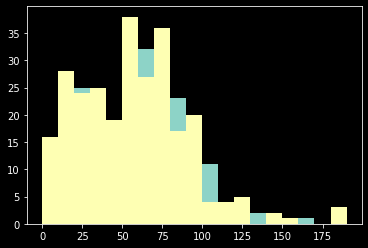

In [49]:
cts = [r["count"].sum() for r in results]
pxs = [len(r) for r in results]
plt.hist(cts,range(0,200,10))
plt.hist(pxs,range(0,200,10))


(array([16., 20., 19., 17., 19., 35., 28., 35., 20., 10.,  5.,  4.,  2.,
         1.,  2.,  0.,  0.,  3.,  0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <BarContainer object of 19 artists>)

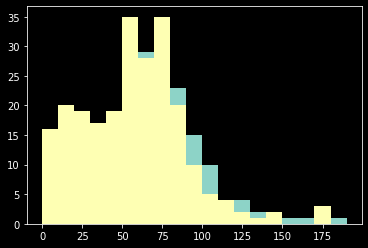

In [50]:
from matplotlib import pyplot as plt
scool_path = '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_10000.scool'
results  = load_scool_pixels(scool_path,"chr1:10000000-12000000",hyper_pixels=False)
cts = [r["count"].sum() for r in results]
pxs = [len(r) for r in results]
plt.hist(cts,range(0,200,10))
plt.hist(pxs,range(0,200,10))


(array([20., 30., 38., 76., 54., 12.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <BarContainer object of 19 artists>)

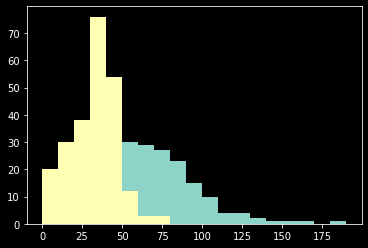

In [51]:
scool_path = '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_100000.scool'
results  = load_scool_pixels(scool_path,"chr1:10000000-12000000",hyper_pixels=False)
cts = [r["count"].sum() for r in results]
pxs = [len(r) for r in results]
plt.hist(cts,range(0,200,10))
plt.hist(pxs,range(0,200,10))


<AxesSubplot:title={'center':'chr1  single cells none zero bins'}, ylabel='Count'>

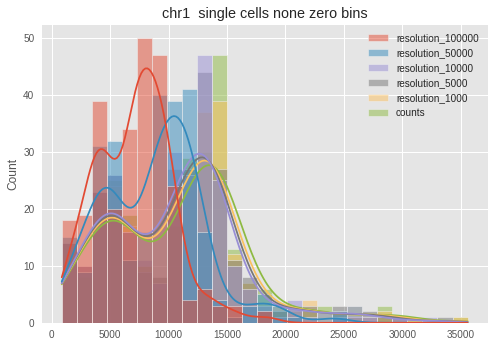

In [96]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
import seaborn as sns
plt.style.use("ggplot")
plt.title(region + "  single cells none zero bins")
sns.histplot(regions_stats,kde=True)

<AxesSubplot:title={'center':'chr3:10000000-20000000  single cells none zero bins'}, ylabel='Count'>

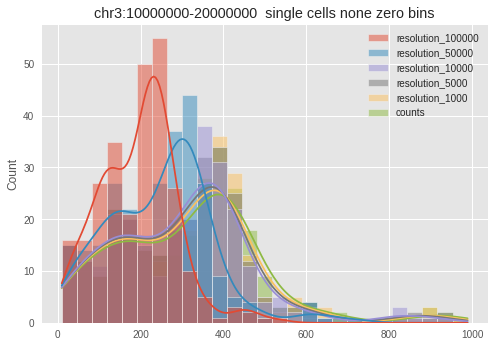

In [95]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr3:10000000-20000000"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
import seaborn as sns
plt.style.use("ggplot")
plt.title(region + "  single cells none zero bins")
sns.histplot(regions_stats,kde=True)

<AxesSubplot:title={'center':'chr1  single cells none zero bins(DipC2021)'}, ylabel='Count'>

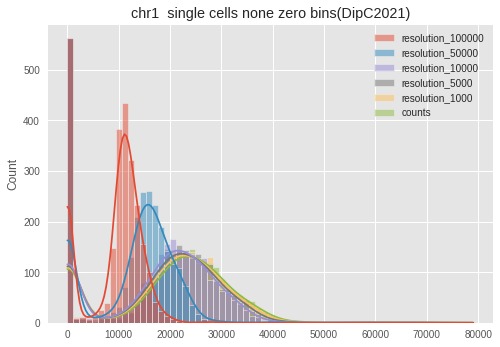

In [97]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/DipC2021/DipC2021_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
import seaborn as sns
plt.style.use("ggplot")
plt.title(region + "  single cells none zero bins(DipC2021)")
sns.histplot(regions_stats,kde=True)


<AxesSubplot:title={'center':'chr1  single cells none zero bins (Embryo2020)'}, ylabel='Count'>

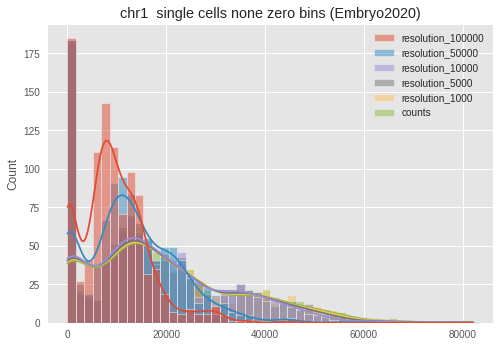

In [98]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/Embryo2020/Embryo2020_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
import seaborn as sns
plt.style.use("ggplot")
plt.title(region + "  single cells none zero bins (Embryo2020)")
sns.histplot(regions_stats,kde=True)


/tmp/ipykernel_19752/3139504879.py:1: RuntimeWarning: invalid value encountered in true_divide
  regions_freq = pd.DataFrame(regions_stats[["counts"]].values / regions_stats[["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]].values )


(0.99, 1.2)

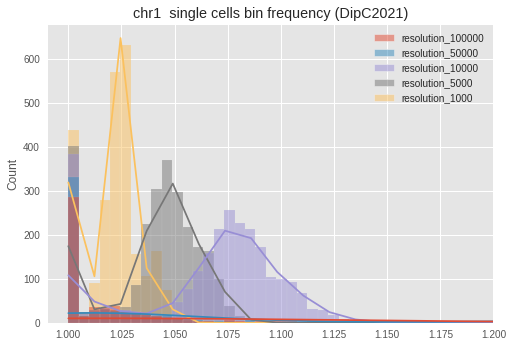

In [167]:
regions_freq = pd.DataFrame(regions_stats[["counts"]].values / regions_stats[["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]].values )
regions_freq.columns = [["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]]
plt.style.use("ggplot")
plt.title(region + "  single cells bin frequency (DipC2021)")
sns.histplot(regions_freq,bins=500,kde=True)
plt.xlim(0.99,1.2)

(0.99, 1.2)

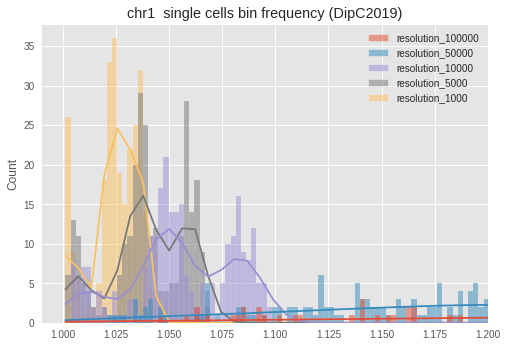

In [168]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
regions_freq = pd.DataFrame(regions_stats[["counts"]].values / regions_stats[["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]].values )
regions_freq.columns = [["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]]
plt.style.use("ggplot")
plt.title(region + "  single cells bin frequency (DipC2019)")
sns.histplot(regions_freq,bins=500,kde=True)
plt.xlim(0.99,1.2)

(0.99, 1.2)

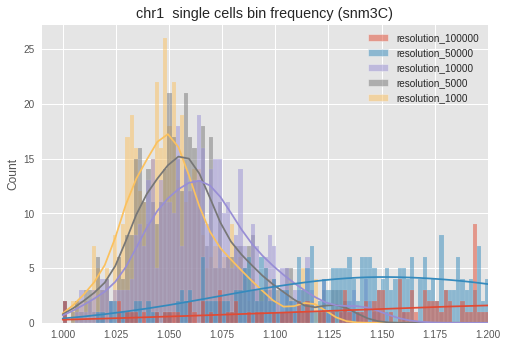

In [169]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
regions_freq = pd.DataFrame(regions_stats[["counts"]].values / regions_stats[["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]].values )
regions_freq.columns = [["resolution_100000","resolution_50000","resolution_10000","resolution_5000","resolution_1000"]]
plt.style.use("ggplot")
plt.title(region + "  single cells bin frequency (snm3C)")
sns.histplot(regions_freq,bins=500,kde=True)
plt.xlim(0.99,1.2)

<AxesSubplot:title={'center':'chr1  single cells none zero bins (snm3C)'}, ylabel='Count'>

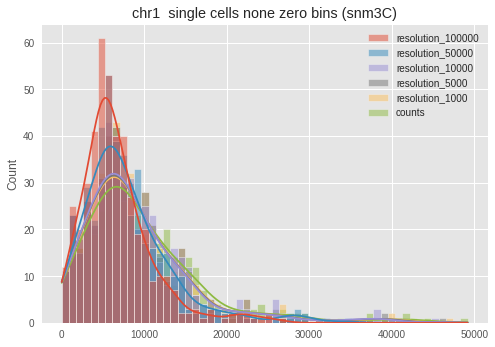

In [145]:
resolutions = [100000,50000,10000,5000,1000]
scools = [f'/store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_{res}.scool' for res in resolutions]
names = [cell.split("/")[-1] for cell in cooler.fileops.list_scool_cells(scools[0])]
regions_stats = pd.DataFrame(names,columns=["name"])
region = "chr1"
for res,scool in zip(resolutions,scools):
    results  = load_scool_pixels(scool,region,hyper_pixels=False)
    regions_stats["resolution_"+str(res)] = [len(r) for r in results]
regions_stats["counts"] = [r["count"].sum() for r in results]
import seaborn as sns
plt.style.use("ggplot")
plt.title(region + "  single cells none zero bins (snm3C)")
sns.histplot(regions_stats,kde=True)

100%|██████████| 447/447 [00:07<00:00, 56.51it/s]


387 passed quality control, with more than 10000 contacts, more than 10000 nonzero bins , intra contacts percentage more than 50.0 %.
Saving quality control figures  to /store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_1000000_qc.png
Saving quality control cells results to /store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_1000000_qc.scool and  /store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_1000000_qc_meta.csv


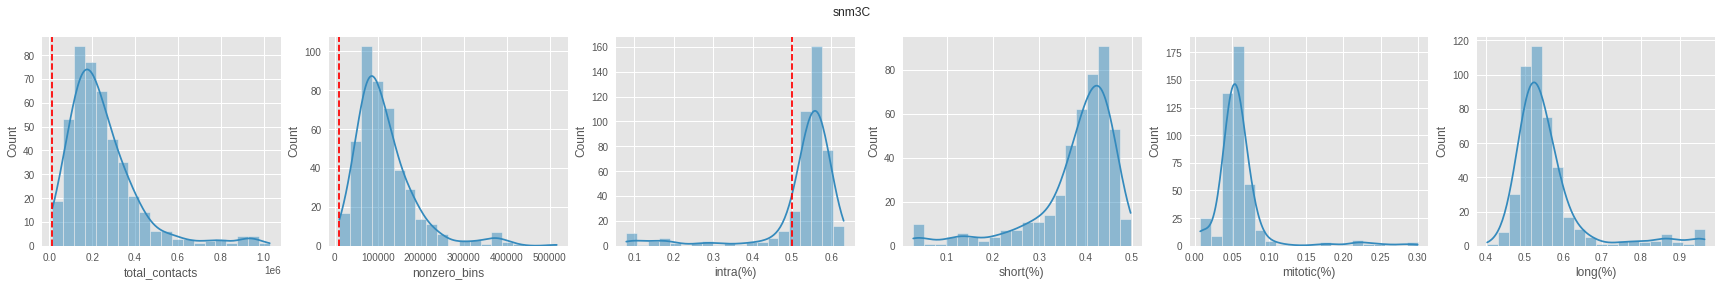

In [147]:
meta_path = "/store/zlwang/Workspace/Myproject/hicool/data/snm3C_Mus_raw_meta.csv"
scool_path = "/store/zlwang/Workspace/Myproject/hicool/data/snm3C_mus/snm3C_mus_1000000.scool"
from hicool.process import plot_stats, quality_control 
qual_scool,qual_path = quality_control(scool_path,meta_path)

In [151]:
pd.read_csv(qual_path)[["total_contacts","short(%)","long(%)","intra(%)","nonzero_bins"]].mean()

total_contacts    252378.687339
short(%)               0.405570
long(%)                0.529329
intra(%)               0.559246
nonzero_bins      113084.098191
dtype: float64

In [160]:
162690 / (2800*2800)

0.02075127551020408

In [164]:
qual_path = "/store/zlwang/Workspace/Myproject/hicool/data/DipC2021/DipC2021_100000_qc_meta.csv"
pd.read_csv(qual_path)[["total_contacts","short(%)","long(%)","intra(%)","nonzero_bins"]]


,total_contacts,short(%),long(%),intra(%),nonzero_bins
0,503696,0.468340,0.458995,0.681457,305535
1,377718,0.585225,0.349163,0.736338,215498
2,365317,0.692774,0.252745,0.801731,193048
3,434395,0.617024,0.324799,0.733952,236022
4,409612,0.503064,0.428510,0.687546,251878
...,...,...,...,...,...
1908,504788,0.673697,0.266177,0.796418,246596
1909,562818,0.640486,0.299703,0.774778,263593
1910,471745,0.425832,0.470407,0.735469,302065
1911,590129,0.601275,0.320974,0.790353,298526


100%|██████████| 1015/1015 [00:30<00:00, 33.49it/s]


840 passed quality control, with more than 10000 contacts, more than 10000 nonzero bins , intra contacts percentage more than 50.0 %.
Saving quality control figures  to /store/zlwang/Workspace/Myproject/hicool/data/Embryo2020/Embryo2020_1000000_qc.png
Saving quality control cells results to /store/zlwang/Workspace/Myproject/hicool/data/Embryo2020/Embryo2020_1000000_qc.scool and  /store/zlwang/Workspace/Myproject/hicool/data/Embryo2020/Embryo2020_1000000_qc_meta.csv


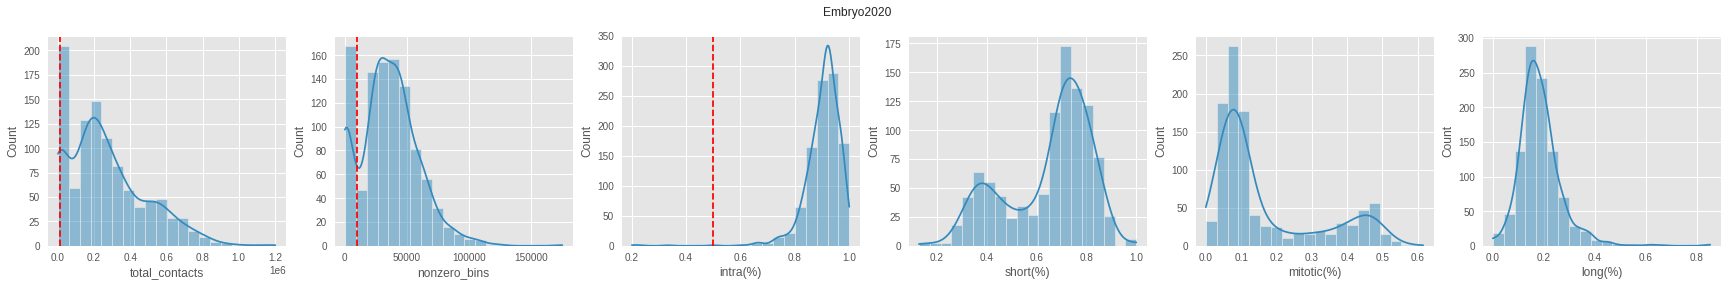

In [154]:
meta_path = "/store/zlwang/Workspace/Myproject/hicool/data/Collombet2019_raw_meta.csv"
scool_path = "/store/zlwang/Workspace/Myproject/hicool/data/Embryo2020/Embryo2020_1000000.scool"
from hicool.process import plot_stats, quality_control 
qual_scool,qual_path = quality_control(scool_path,meta_path)

In [23]:
for cell in cell_list:
    fast_oe(cell,store=True)

/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3588984_cell_146


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3589011_cell_173


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3589022_cell_184


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3589035_cell_197


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3589041_cell_203
Writing OE normalized matrix to  /store/zlwang/Workspace/Myproject/hicool/tests/Test/Test_100000.scool::/cells/GSM3589060_cell_222


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):


In [24]:
oe_adjs = load_scool_adj(scool,transform='OE')

In [25]:
oe_adjs = load_scool_adj(scool,field='OE')

In [26]:
oe = oe_adjs[0]
comp = compartment_decomposition(cell,chrom='chr1',return_vector=False)
tad = tad_insulation(cell,chrom='chr1')


<AxesSubplot:>

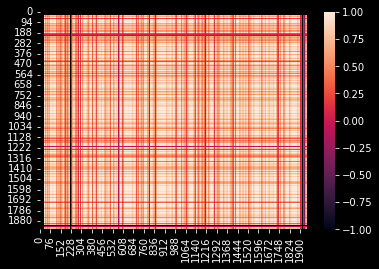

In [27]:
import seaborn as sns
sns.heatmap(comp)

In [19]:
oe_adjs = load_cool_adj(cool_path,transform='OE')

In [12]:
sample1_path

'/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_100000.scool::/cells/GSM3588980_cell_142'

In [36]:

oe_adjs[oe_adjs>5] = 5

In [39]:
pd.DataFrame(oe_adjs.numpy()).to_csv('/store/wcsun/sigle_cell_hic/embedding_max/data/oe_adjs.csv',index=0,header=0)

In [2]:
cool_path =  '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_100000_merged.cool'
chrom = 'chr1'
clr = cooler.Cooler(cool_path)
raw_adj = clr.matrix(balance=False).fetch(chrom,chrom)

In [3]:
comp_adj = compartment_adj(cool_path,chrom='chr1')

In [4]:
t_adj = tad_adj(cool_path,chrom='chr1')

In [17]:
raw_adj

,0,1,2,3,4,5,6,7,8,9,...,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,0,0,0,0,0,0,0,0,0,0,...,17,27,39,93,214,421,171,33,16,0
1951,0,0,0,0,0,0,0,0,0,0,...,19,25,33,64,109,171,487,137,20,0
1952,0,0,0,0,0,0,0,0,0,0,...,18,2,17,20,27,33,137,286,54,0
1953,0,0,0,0,0,0,0,0,0,0,...,4,4,1,11,6,16,20,54,131,0


In [12]:
raw_adj=pd.DataFrame(raw_adj)
raw_adj.to_csv('/store/wcsun/sigle_cell_hic/embedding_max/data/raw_adj.csv',index=0,header=0)

In [14]:
comp_adj2=pd.DataFrame(comp_adj).fillna(0)

In [41]:
comp_adj2.to_csv('/store/wcsun/sigle_cell_hic/embedding_max/data/comp_adj2.csv',index=0,header=0)

In [45]:
pd.DataFrame(t_adj).fillna(0).to_csv('/store/wcsun/sigle_cell_hic/embedding_max/data/t_adj.csv',index=0,header=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<AxesSubplot:>

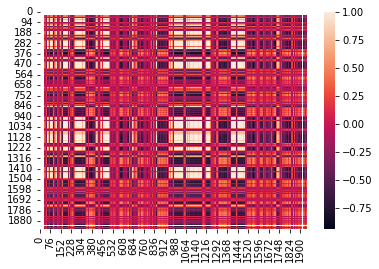

In [16]:
import seaborn as sns
sns.heatmap(comp_adj)

<AxesSubplot:>

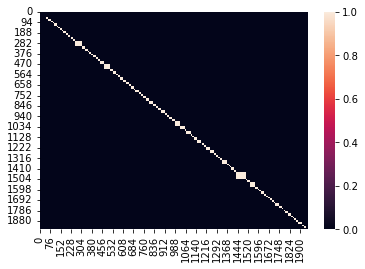

In [5]:
sns.heatmap(t_adj)